## Final Project Submission

Please fill out:
* Student name: Markus


In [1]:
# Your code here - remember to use markdown cells for comments as well!

In [2]:
reset -fs

In [3]:
#importing the necessary packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_profiling
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

%matplotlib inline


In [4]:
df = pd.read_csv('King_County_House_prices_dataset.csv')

In [5]:
#Anzeigen aller Werte, die nicht numerisch sind. isreal aus der np-Lib.
#df.applymap(np.isreal)

In [6]:
#Cleaning and specification

#Drop view, sqft_lot15
del df['view']
#del df['sqft_lot15']

#Überschreiben der NaN in Spalte 'waterfront'
df['waterfront'].fillna(value = 0, inplace=True)

#Überschreiben der Fragezeichen "?"
df['sqft_basement'] = df['sqft_basement'].str.replace('?','0')
df['sqft_basement'] = df['sqft_basement'].astype(float).astype(int)

#Boolean for renovated (0 = False, 1 = True)
df['was_renovated'] = df['yr_renovated']
df.loc[df.was_renovated > 0, 'was_renovated'] = 1
df.loc[df.was_renovated != 1, 'was_renovated'] = 0
df['was_renovated'] = df['was_renovated'].astype(float).astype(int)
#df['was_renovated'].value_counts()

#Replaces NaN and empty cells with yr_built

df['renovated'] = df['yr_renovated']
df.loc[df.renovated > 0, 'renovated'] = df.renovated
df.loc[df.renovated != 1, 'renovated'] = df.yr_built
df['renovated'] = df['renovated'].astype(float).astype(int)

#Überschreiben der NaN-Werte in yr_renovated mit 0
#Und passe entsprechend renovated an
df['yr_renovated'] = df.yr_renovated.replace(np.NaN, '0')
df['yr_renovated'] = df['yr_renovated'].astype(float).astype(int)

#Split date by day, month and year
df[['day','month', 'year']] = df['date'].str.split('/',expand=True)

#Define Feature age
df['age'] = (2020 - (df['yr_built'].astype(int)))


In [7]:
#Anzeigen aller Rows mit "?". Es sollten keine Rows mehr auftauchen.
#df[df["sqft_basement"].str.contains('\?', na=False)] # wurden die '?' gelöscht?

In [8]:
#Add features living_price_sqft and lot_price_sqft sowie bath_bed_ratio
#temp_df = df
df['living_price_sqft'] = df['price'] / df['sqft_living']
df['lot_price_sqft'] = df['price'] / df['sqft_lot']
df['bath_bed_ratio'] = df['bathrooms'] / df['bedrooms']
df['sqft_prod'] = (df['sqft_living'] * df['sqft_living15'])**(1/2)

In [9]:
from numpy import cos, sin, arcsin, sqrt
from math import radians

#Coordinates of main Google Office in Seattle
google_lat = 47.649210
google_long = -122.350370
google_lat_long = (47.649210, -122.350370)

def haversine(long, lat):
    lon1 = -122.350370
    lat1 = 47.649210
    lon2 = long
    lat2 = lat
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a)) 
    km = 6367 * c
    return km

df['distance'] = df.apply(lambda row: haversine(row['long'], row['lat']), axis=1)
#df[['price', 'long', 'lat', 'distance']]
#df.sort_values(by='distance', ascending=False)

In [10]:
#Simple approach to calculate classes "Grading" for neighborhoods (classes from 1 to 5 - cheap to expensive)
conditions = [
    (df['price'] > 1000000),
    (df['price'] > 800000),
    (df['price'] > 600000),
    (df['price'] > 200000),
    (df['price'] > 0)]
choices = ['5', '4', '3', '2', '1']
df['zip_price_class'] = np.select(conditions, choices, default='9000')
#df.head(20)
#temp_df['zip_price_class'].unique()


In [11]:
#Creation of a subset with criteria of customer requirements

fam_distance_max =  20
fam_monthly_mortgage = 4000 #per month
fam_bedrooms = 3 #min()
fam_bathrooms = 2 #min()

subset_family = df[(df.bathrooms >= fam_bathrooms) 
                   & (df.bedrooms >= fam_bathrooms) 
                   & (df.price <= (20 * 12 * fam_monthly_mortgage))
                   & (df.distance <= fam_distance_max)]
subset_family.head()
subset_family.price.mean()

572689.1296638345

In [12]:
#Remove all Outliers (cell-wise) per Column. Deletion of rows afterwards (dropna)

def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.05)
    Q3 = df.quantile(0.95)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

# Index List of Non-Outliers
nonOutlierList = Remove_Outlier_Indices(subset_family)
#print(nonOutlierList)

# Non-Outlier Subset of the Given Dataset
subset_family = subset_family[nonOutlierList]

#Drop NA in df dataframe
subset_family = subset_family.dropna()

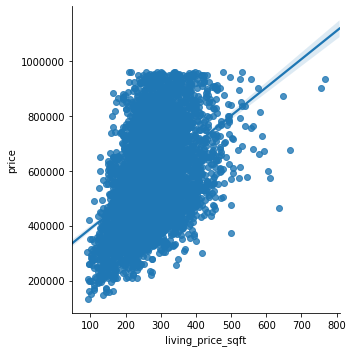

In [13]:
sns.lmplot(x="living_price_sqft", y="price", data=subset_family)

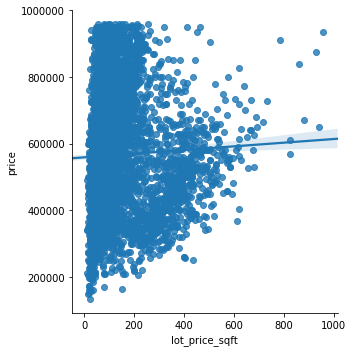

In [14]:
sns.lmplot(x="lot_price_sqft", y="price", data=subset_family)

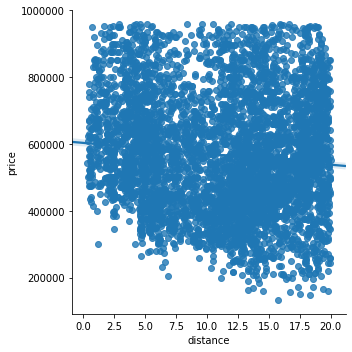

In [15]:
sns.lmplot(x="distance", y="price", data=subset_family)

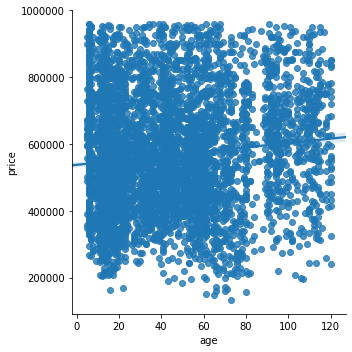

In [16]:
sns.lmplot(x="age", y="price", data=subset_family)
#subset_family.age

In [17]:
#sns.lmplot(x="zip_price_class", y="price", data=df)

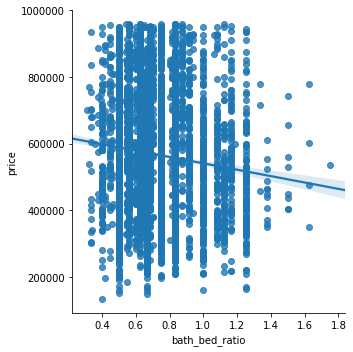

In [18]:
sns.lmplot(x="bath_bed_ratio", y="price", data=subset_family)

In [19]:
#Validation of data quality / isnull and isna
#df.isnull().sum(), df.isna().sum()

In [20]:
train_df, test_df = train_test_split(subset_family, test_size=0.2)

In [23]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

In [24]:
profile = ProfileReport(train_df, title='Pandas Profiling Report', html={'style':{'full_width':True}})

TypeError: _plot_histogram() got an unexpected keyword argument 'title'

In [25]:
profile.to_widgets()

NameError: name 'profile' is not defined

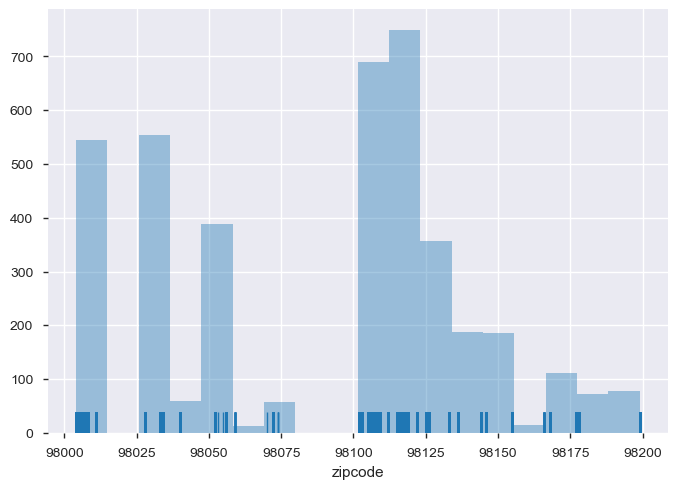

In [26]:
#zip_view = df.groupby(df['zipcode']).count()
#zip_view = pd.cut(df['zipcode'], bins=np.arange(98000, 98220, 20))
#zip_view
sns.distplot(train_df['zipcode'], kde=False, rug=True);

In [27]:
#temp = train_df[['price', 'bedrooms', 'sqft_living', 'condition', 'grade', 'zipcode']]
#sns.pairplot(temp);

In [28]:
subset_family.columns.values

array(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'was_renovated', 'renovated', 'day', 'month', 'year', 'age',
       'living_price_sqft', 'lot_price_sqft', 'bath_bed_ratio',
       'sqft_prod', 'distance', 'zip_price_class'], dtype=object)

In [29]:
#type(df['sqft_basement'])
#df['sqft_basement'].head(50)
#df['sqft_basement'].astype('int32').dtypes
#pd.Series(df['sqft_basement']).str.replace(',', '').astype(int)

#temp['sqft_basement']

#df["sqft_basement"][400:500]


In [30]:
#df['sqft_basement'][100:200].
#df.applymap(np.isreal).all(1)
#np.argmin(df.applymap(np.isreal).all(1))
#Binäre Darstellung, invertiert die "Echtheit" auf Numerischen Value prüft
#df[~df.applymap(np.isreal).all(1)]

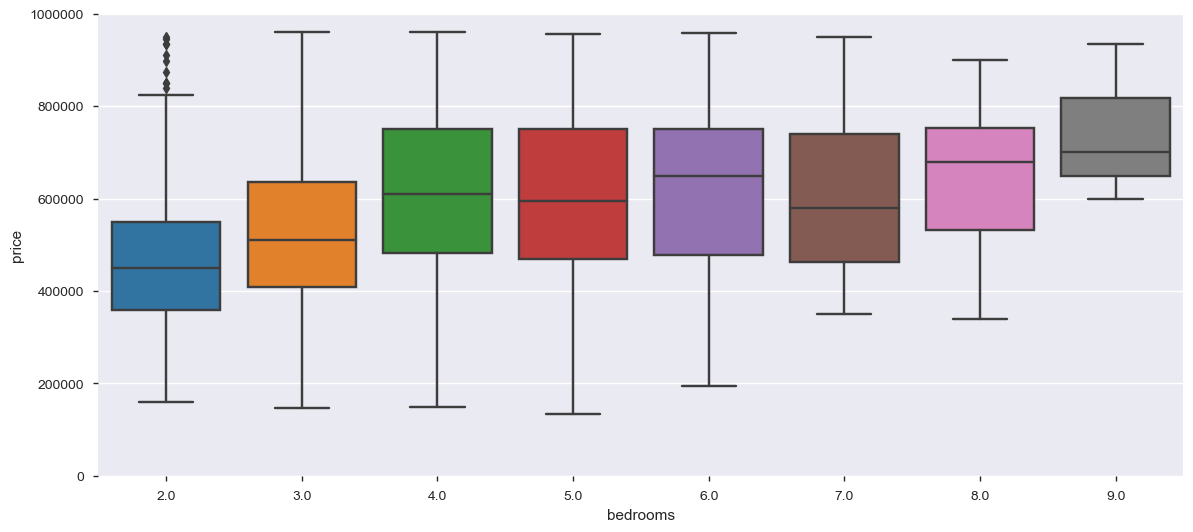

In [31]:
#Plot von 'bedrooms' in subset_family  
var = 'bedrooms'
data = pd.concat([subset_family['price'], subset_family[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.boxplot(x=var, y="price", data=data)
#fig.axis(ymin=0, ymax=3500000);
fig.axis(ymin=0, ymax=1000000);

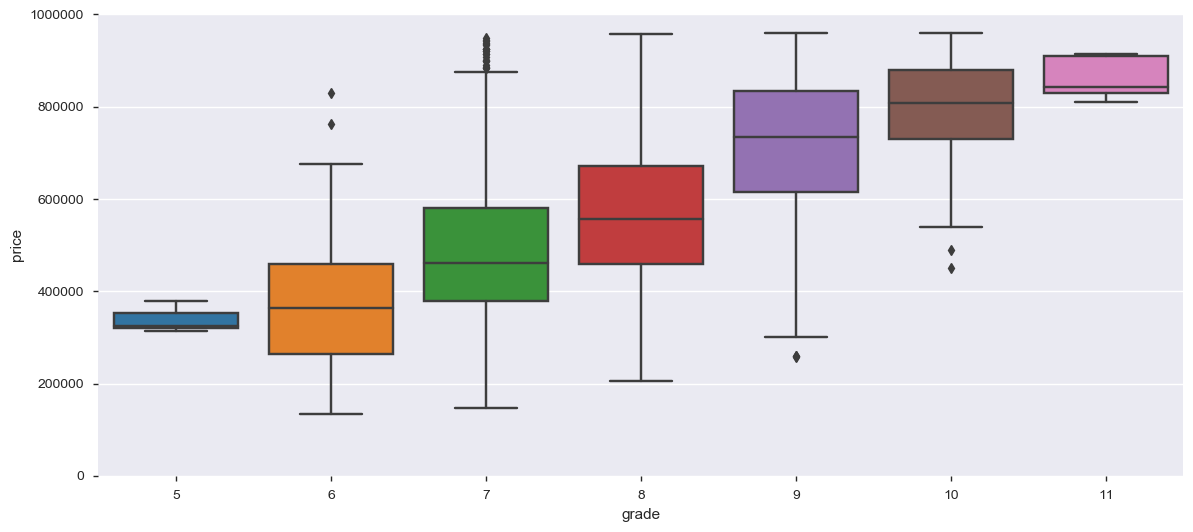

In [32]:
#Plot von 'grade' in subset_family  
var = 'grade'
data = pd.concat([subset_family['price'], subset_family[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.boxplot(x=var, y="price", data=data)
#fig.axis(ymin=0, ymax=3500000);
fig.axis(ymin=0);

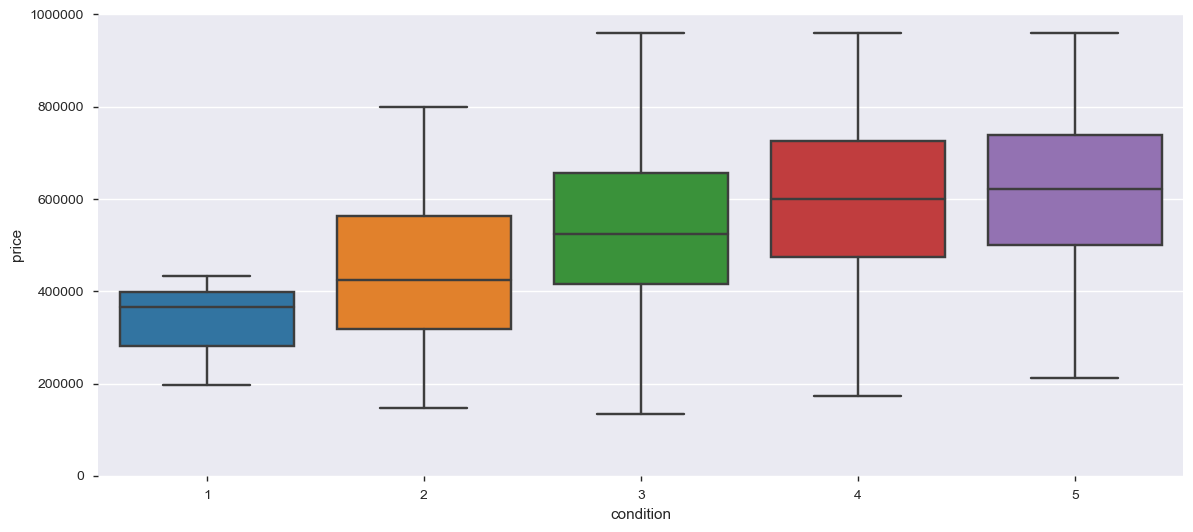

In [36]:
#Plot von 'grade' in subset_family  
var = 'condition'
data = pd.concat([subset_family['price'], subset_family[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.boxplot(x=var, y="price", data=data)
#fig.axis(ymin=0, ymax=3500000);
fig.axis(ymin=0);

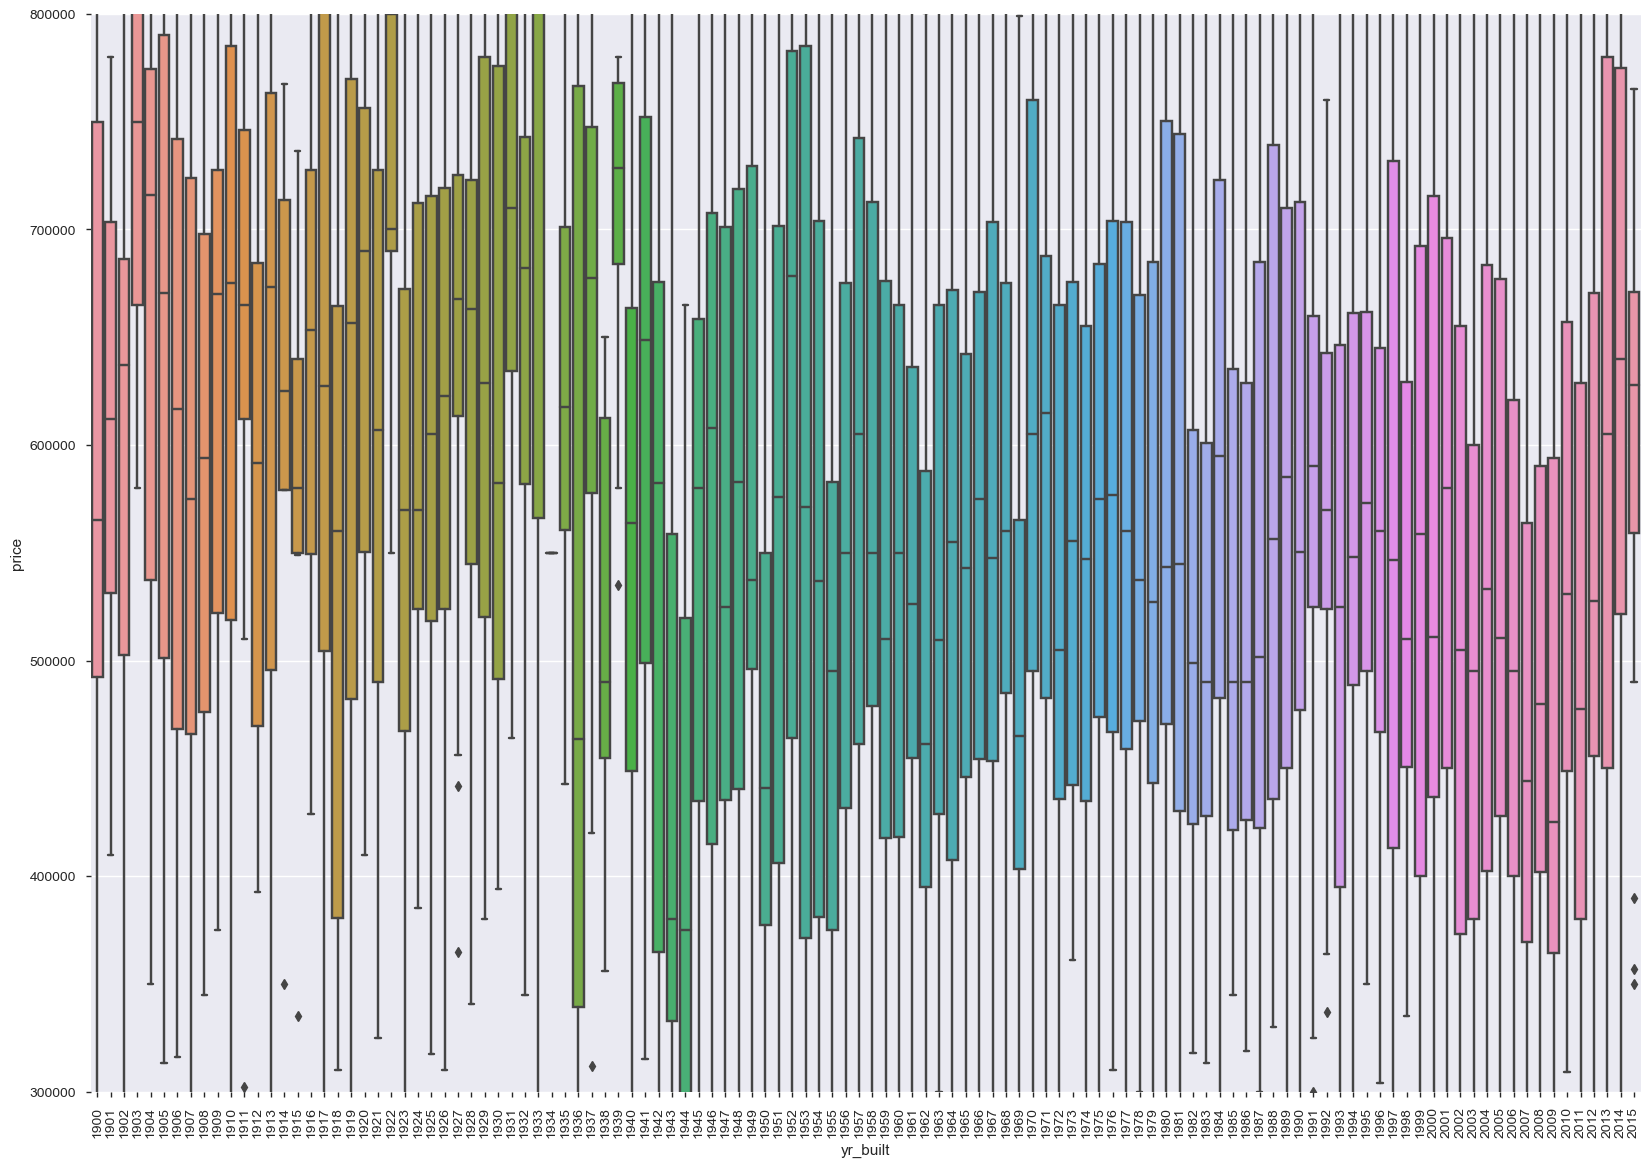

In [37]:
#Plot von 'yr_built' in subset_family  
var = 'yr_built'
data = pd.concat([subset_family['price'], subset_family[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 14))
fig = sns.boxplot(x=var, y="price", data=data)
fig.axis(ymin=300000, ymax=800000);
plt.xticks(rotation=90);

In [38]:
df.was_renovated.unique()

array([0, 1])

In [39]:
# Set theme
#sns.set_style('whitegrid')
 
# Violin plot
#fig = sns.violinplot(x='grade', y='price', hue='was_renovated', data=train_df, split=True, scale="count")
#fig.axis(ymax=2000000);

In [40]:
model1 = smf.ols(formula='price ~ bathrooms + bedrooms + grade + lat + sqft_above + sqft_living + sqft_living15 + sqft_basement', data=train_df).fit().summary()
#model1 = smf.ols(formula='price ~ bathrooms + bedrooms + grade + lat + view + sqft_above + sqft_living + sqft_living15', data=df).fit().summary()
#df.columns.values

model2 = smf.ols(formula='price ~ bathrooms + bedrooms + grade + lat + sqft_above + sqft_living + sqft_basement', data=train_df).fit().summary()
model3 = smf.ols(formula='price ~ bathrooms + bedrooms + grade + lat + sqft_living +  sqft_basement', data=train_df).fit().summary()
model4 = smf.ols(formula='price ~ bath_bed_ratio + grade + distance + sqft_living + waterfront + renovated + age', data=train_df).fit().summary()

model4

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     1051.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:02:37   Log-Likelihood:                -53048.
No. Observations:                4060   AIC:                         1.061e+05
Df Residuals:                    4054   BIC:                         1.061e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.4756      0.031     15.485      0.000       0.415       0.536
bath_bed_ratio -1.217e+04   1.09e+04     -1.122      0.262   -3.34e+04    9102.333
grade           9.402e+04   2805.848     33.508      0.000    8.85e+04    9.95e+04
distance       -8034.7093    362.936    -22.138      0.000   -8746.264   -7323.155
sqft_living      122.8393      3.545     34.648      0.000     115.888     129.790
waterfront     -1.169e-11   9.37e-13    -12.476      0.000   -1.35e-11   -9.86e-12
renovated       -193.8222     11.203    -17.301      0.000    -215.786    -171.858
age             1154.4995     67.040     17.221      0.000    1023.064    1285.935
==============================================================================
Omnibus:                       50.336   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.615
Skew:                           0.172   Prob(JB):                     3.43e-15
Kurtosis:                       3.525   Cond. No.                     2.56e+21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.46e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

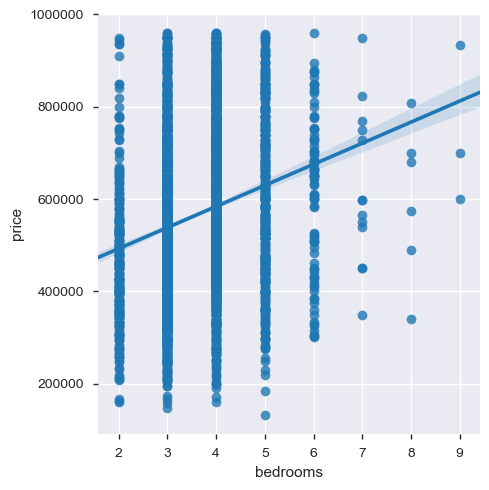

In [41]:
model5 = smf.ols(formula='price ~ bath_bed_ratio', data=train_df).fit().summary()
model5

sns.lmplot(x='bedrooms', y='price', data=train_df)

In [42]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sms

%matplotlib inline

In [43]:
subset_family.columns.values

array(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'was_renovated', 'renovated', 'day', 'month', 'year', 'age',
       'living_price_sqft', 'lot_price_sqft', 'bath_bed_ratio',
       'sqft_prod', 'distance', 'zip_price_class'], dtype=object)

In [44]:
#price ~ bath_bed_ratio + grade + distance + sqft_living + waterfront + renovated + age
#constants = ['bath_bed_ratio', 'grade', 'distance', 'sqft_living', 'waterfront', 'age', 'living_price_sqft']
constants = ['bath_bed_ratio', 'grade', 'distance', 'waterfront', 'age', 'sqft_prod']
X = train_df[constants]
X = sms.add_constant(X)
y = train_df.price

#model16 = smf.ols(formula='price ~ sqft_living', data=subset_family).fit().summary()

model = sms.OLS(y, X).fit()
#model.summary()

/Users/maehm/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [45]:
#price ~ bedrooms + grade + lat + view + sqft_living
X_test = test_df[constants]
X_test = sms.add_constant(X_test)
y_test = test_df.price

#y_test.hist()

In [46]:
pred_prices = model.get_prediction(X_test)
error = abs(pred_prices.predicted_mean - y_test)/y_test
error.mean()

0.16413877380179193

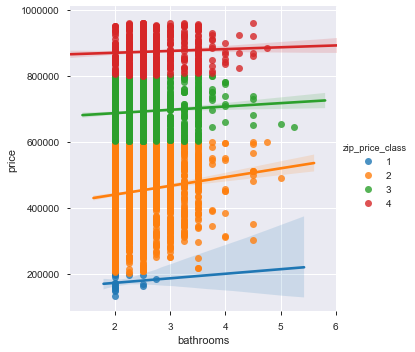

In [47]:
sns.lmplot(x="bathrooms", y="price", hue="zip_price_class", data=subset_family)

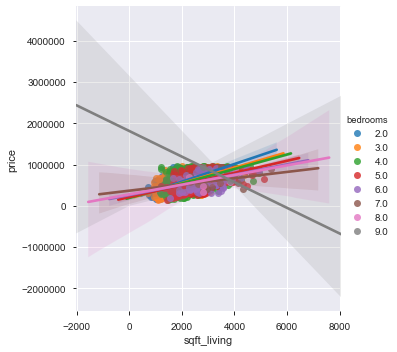

In [48]:
sns.lmplot(x="sqft_living", y="price", hue="bedrooms", data=subset_family)

/Users/maehm/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


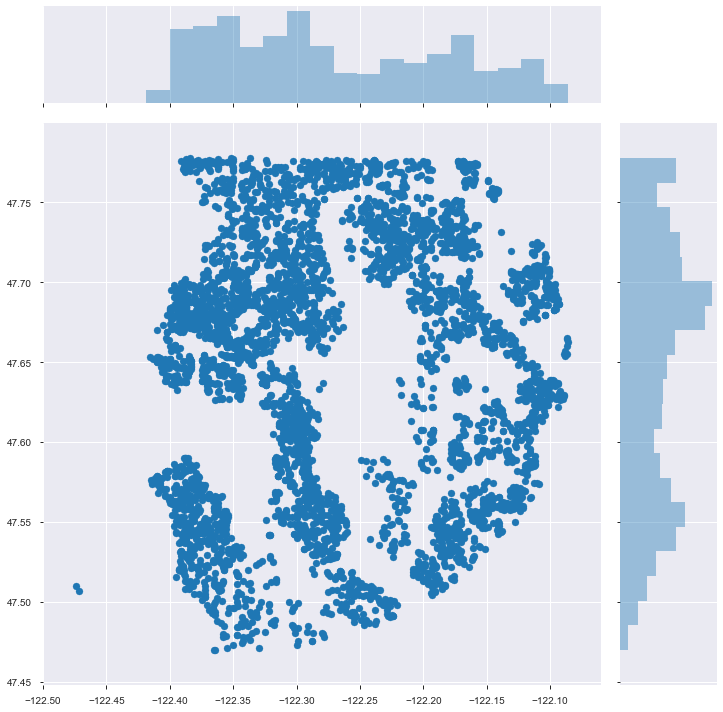

In [49]:
sns.jointplot(x=subset_family.long.values, y=subset_family.lat.values, size=10)

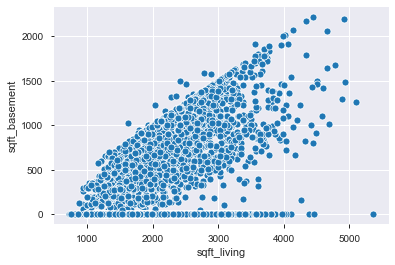

In [50]:
sns.scatterplot(x='sqft_living', y='sqft_basement', data=subset_family)

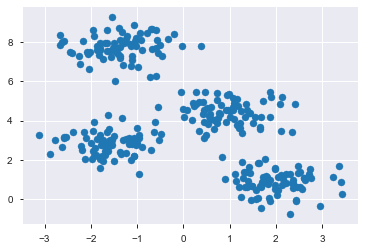

In [51]:
from sklearn.datasets.samples_generator import make_blobs

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [52]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

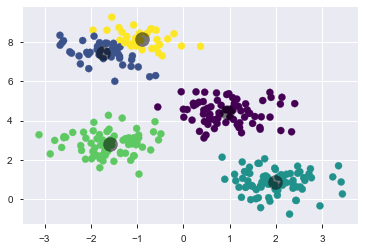

In [53]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);